In [1]:
import os

# %matplotlib notebook 
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

C_mu = 0.09
SYMTENSORDIM = 6
TENSORSQRTDIM = 3
TENSORDIM = 9
DEVSYMTENSORDIM = 5
DEVSYMTENSOR_INDEX = [0,1,2,4,5]


# Case

In [2]:
foam_dir = '../foam_primal'
results_dir = 'results'
data_dir = '../data'
save_dir = '/l/cmich/transfer'
cpp_dir = '/l/cmich/AFRL/cases/channel_linear/case_trainedTurbModel/data'

tinit = 0
tint = 1
tfinal = 100

flow = 0
regularization = False

plot_full_channel = False
plot_int = True
plot_cpp = False
savefigs = False

points = [(1.07, 0.25),]

H = 0.5

In [3]:
def get_tensor_basis(gradU, time_scale):
    ncells = len(time_scale)
    assert len(gradU)==ncells
    T = np.zeros([ncells, DEVSYMTENSORDIM])
    for i, (igradU, it) in enumerate(zip(gradU, time_scale)):
        # velocity gradient: symmetric and anti-symmetric components
        igradU = igradU.reshape([TENSORSQRTDIM, TENSORSQRTDIM])
        S = it * 0.5*(igradU + igradU.T)

        T1 = S.reshape([TENSORDIM])
        symmetric = True
        symm_pairs = [(1, 3), (2, 6), (5, 7)]
        for (si, sj) in symm_pairs:
            symmetric = symmetric and np.isclose(T1[si], T1[sj])
        deviatoric = np.isclose(-(T1[0]+T1[4]), T1[8])
        assert (symmetric and deviatoric)
        T[i, :] = T1[DEVSYMTENSOR_INDEX]
    return T

def get_b(g, gradU, time_scale):
    T = get_tensor_basis(gradU, time_scale)
    return np.expand_dims(g,-1) * T

def b2a(b, k):
    return 2 * np.expand_dims(k, -1) * b

In [8]:
def get_scalar_invariants(gradU, time_scale):
    ncells = len(time_scale)
    assert len(gradU)==ncells
    theta = np.zeros([ncells, 1])
    for i, (igradU, it) in enumerate(zip(gradU, time_scale)):
        igradU = igradU.reshape([TENSORSQRTDIM, TENSORSQRTDIM])
        S = it * 0.5*(igradU + igradU.T)
        theta[i, 0] = np.trace(S@S)
    return theta

In [14]:
# y
y = np.loadtxt(os.path.join(data_dir, 'y')) / H
ncells = len(y)
if plot_full_channel:
    y = np.concatenate([y, y+0.5/H])

# cost & weights
J = []
W = []
if regularization:
    J0 = []
for i in range(tfinal+1):
    iJ = np.loadtxt(os.path.join(results_dir, f'J.{i}'))
    J.append(iJ.tolist())
    iW = np.loadtxt(os.path.join(results_dir, f'w.{i}'))
    W.append(iW)
    if regularization:
        iJ0 = np.loadtxt(os.path.join(results_dir, f'J_org.{i}'))
        J0.append(iJ0.tolist())
W = np.array(W)
nweights = W.shape[1]

# truth 
g_t = np.zeros([len(y)])
g_t[:] = -C_mu * np.ones(ncells) 
U_t = np.loadtxt(os.path.join(data_dir, 'UxFullField'))
T_t = np.load(os.path.join(data_dir, 'basis_tensors.npy'))[:, :, 0]
tke_t = np.load(os.path.join(data_dir, 'tke.npy'))
b_t = np.expand_dims(g_t,-1) * T_t
theta_t = np.load(os.path.join(data_dir, 'scalar_invariants.npy'))[:, 0]
a_t = b2a(b_t, tke_t)
if plot_full_channel:
    g_t = np.concatenate([g_t, g_t[::-1]])
    U_t = np.concatenate([U_t, U_t[::-1]])
    b_t = np.concatenate([b_t, b_t[::-1]])
    a_t = np.concatenate([a_t, a_t[::-1]])

# C++ 
g_c = np.loadtxt(os.path.join(cpp_dir, 'g'))
U_c = np.loadtxt(os.path.join(cpp_dir, 'ux'))
T_c = np.load(os.path.join(cpp_dir, 'basis_tensors.npy'))[:, :, 0]
tke_c = np.load(os.path.join(cpp_dir, 'tke.npy'))
b_c = np.expand_dims(g_c,-1) * T_c
a_c = b2a(b_c, tke_c)
if plot_full_channel:
    g_c = np.concatenate([g_c, g_c[::-1]])
    U_c = np.concatenate([U_c, U_c[::-1]])
    b_c = np.concatenate([b_c, b_c[::-1]])
    a_c = np.concatenate([a_c, a_c[::-1]])

# initial
g_0 = np.loadtxt(os.path.join(results_dir, f'g.{tinit}')) 
U_0 = np.loadtxt(os.path.join(results_dir, f'U.flow_{flow}.{tinit}'))[:, 0]
gradU_0 = np.loadtxt(os.path.join(results_dir, f'gradU.flow_{flow}.{tinit}'))
time_scale_0 = np.loadtxt(os.path.join(results_dir, f'timeScale.flow_{flow}.{tinit}'))
tke_0 = np.loadtxt(os.path.join(results_dir, f'tke.flow_{flow}.{tinit}'))
b_0 = get_b(g_0, gradU_0, time_scale_0)
a_0 = b2a(b_0, tke_0)
W_0 = np.loadtxt(os.path.join(results_dir, f'w.{tinit}'))
theta_0 = get_scalar_invariants(gradU_0, time_scale_0)
if plot_full_channel:
    g_0 = np.concatenate([g_0, g_0[::-1]])
    U_0 = np.concatenate([U_0, U_0[::-1]])
    b_0 = np.concatenate([b_0, b_0[::-1]])
    a_0 = np.concatenate([a_0, a_0[::-1]])

# intermediate
if plot_int:
    g_i = np.loadtxt(os.path.join(results_dir, f'g.{tint}')) 
    U_i = np.loadtxt(os.path.join(results_dir, f'U.flow_{flow}.{tint}'))[:, 0]
    gradU_i = np.loadtxt(os.path.join(results_dir, f'gradU.flow_{flow}.{tint}'))
    time_scale_i = np.loadtxt(os.path.join(results_dir, f'timeScale.flow_{flow}.{tint}'))
    tke_i = np.loadtxt(os.path.join(results_dir, f'tke.flow_{flow}.{tint}'))
    b_i = get_b(g_i, gradU_i, time_scale_i)
    a_i = b2a(b_i, tke_i)
    W_i = np.loadtxt(os.path.join(results_dir, f'w.{tint}'))
    if plot_full_channel:
        g_i = np.concatenate([g_i, g_i[::-1]])
        U_i = np.concatenate([U_i, U_i[::-1]])
        b_i = np.concatenate([b_i, b_i[::-1]])
        a_i = np.concatenate([a_i, a_i[::-1]])

# final
g_1 = np.loadtxt(os.path.join(results_dir, f'g.{tfinal}')) 
U_1 = np.loadtxt(os.path.join(results_dir, f'U.flow_{flow}.{tfinal}'))[:, 0]
gradU_1 = np.loadtxt(os.path.join(results_dir, f'gradU.flow_{flow}.{tfinal}'))
time_scale_1 = np.loadtxt(os.path.join(results_dir, f'timeScale.flow_{flow}.{tfinal}'))
tke_1 = np.loadtxt(os.path.join(results_dir, f'tke.flow_{flow}.{tfinal}'))
b_1 = get_b(g_1, gradU_1, time_scale_1)
a_1 = b2a(b_1, tke_1)
W_1 = np.loadtxt(os.path.join(results_dir, f'w.{tfinal}'))
theta_1 = get_scalar_invariants(gradU_1, time_scale_1)
if plot_full_channel:
    g_1 = np.concatenate([g_1, g_1[::-1]])
    U_1 = np.concatenate([U_1, U_1[::-1]])
    b_1 = np.concatenate([b_1, b_1[::-1]])
    a_1 = np.concatenate([a_1, a_1[::-1]])

# Training

### Cost

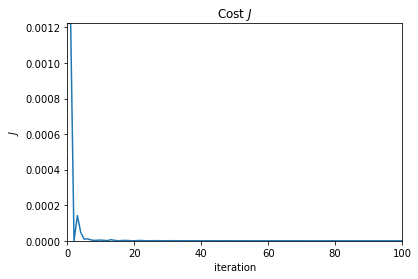

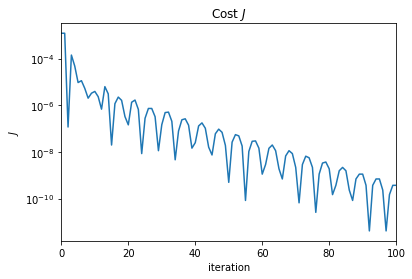

In [9]:
fig, ax = plt.subplots()
ax.plot(J[:tfinal+1], '-')
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'$J$')
ax.set_title(r'Cost $J$')
ax.set_ylim(0., np.max(J[:tfinal+1]))
ax.set_xlim(0., tfinal)
if savefigs:
    plt.savefig(save_dir + '/channel_cost.pdf')
    
fig, ax = plt.subplots()
ax.semilogy(J[:tfinal+1], '-')
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'$J$')
ax.set_title(r'Cost $J$')
ax.set_xlim(0., tfinal)
if savefigs:
    plt.savefig(save_dir + '/channel_cost_log.pdf')

### Weights (initial and final values)

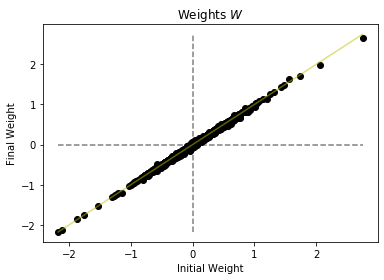

In [10]:
plt.figure()
plt.title(r'Weights $W$')
plt.xlabel(r'Initial Weight')
plt.ylabel(r'Final Weight')

line = [min(np.min(W_0), np.min(W_1)), max(np.max(W_0), np.max(W_1))]
plt.plot(line, [0., 0.], 'k--', alpha=0.5)
plt.plot([0., 0.], line, 'k--', alpha=0.5)

plt.plot(W_0, W_1, 'ko')
plt.plot(line,line, 'y-', alpha=0.5)

if savefigs:
    plt.savefig(save_dir + '/channel_weights.pdf')

# PUBLICATION RESULTS PLOTS

In [11]:
import matplotlib as mpl
mpl.use("pgf")
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.autolayout': True,
    'axes.grid': False,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'savefig.dpi': 500,
    'lines.linewidth': 2,
    'lines.markersize': 6,
})

# Figure sizes: JFM text width = 5.3 in, aspect ratio of 1.6 looks good
jfm_one = [4.0, 2.5] # JFM single image
jfm_two = [2.2, 2.4] # JFM two images

ylim = 0.5/H
if plot_full_channel:
    ylim *= 2.0


# legend 
label_0 = 'Initial'
label_i = 'Intermediate'
label_1 = 'Final'
label_t = 'Truth'
label_o = 'Observation'
label_c = 'Trained'

line_0 = {'linestyle': '-.', 'marker': None, 'color': 'tab:red'}
line_i = {'linestyle': ':', 'marker': None, 'color': 'tab:cyan'}
line_1 = {'linestyle': '--', 'marker': None, 'color': 'tab:blue'}
line_t = {'linestyle': '-', 'marker': None, 'color': 'tab:gray', 'linewidth': 1.0}
line_o = {'linestyle': 'None', 'marker': 'o', 'fillstyle':'none', 'color': 'tab:gray'}
line_c = {'linestyle': ':', 'marker': None, 'color': 'tab:purple', 'linewidth':3}

getline = lambda x: mpl.lines.Line2D([0], [0], **x)
if plot_int:
    lines = [getline(line_t), getline(line_o), getline(line_0), getline(line_i), getline(line_1)]
    labels = [label_t, label_o, label_0, label_i, label_1]
else:
    lines = [getline(line_t), getline(line_o), getline(line_0), getline(line_1)]
    labels = [label_t, label_o, label_0, label_1]
if plot_cpp:
    lines.append(getline(line_c))
    labels.append(label_c)

fig = plt.figure(figsize = jfm_two)
fig.legend(lines, labels, 'center')
if savefigs:
    fig.savefig(save_dir + '/channel_legend.pgf')
    fig.savefig(save_dir + '/channel_legend.pdf')


<Figure size 158.4x172.8 with 0 Axes>

## Scalar function g

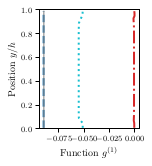

In [12]:

plt.figure(figsize = jfm_two)

# initial
plt.plot(g_0, y, **line_0, label=label_0)

# intermediate
if plot_int:
    plt.plot(g_i, y, **line_i, label=label_i)

# final
plt.plot(g_1, y, **line_1, label=label_1)

# C++
if plot_cpp:
    plt.plot(g_c, y, **line_c, label=label_c)

# truth
plt.plot(g_t, y, **line_t, label=label_t)

# layout
plt.xlabel(r'Function $g^{(1)}$')
plt.ylabel('Position $y/h$') 
plt.ylim([0.0, ylim])  

# save
if savefigs:
    plt.savefig(save_dir + '/channel_g.pgf')
    plt.savefig(save_dir + '/channel_g.pdf')

## Velocity

In [ ]:

plt.figure(figsize = jfm_two)

# initial
plt.plot(U_0, y, **line_0, label=label_0)

# intermediate
if plot_int:
    plt.plot(U_i, y, **line_i, label=label_i)

# final
plt.plot(U_1, y, **line_1, label=label_1)

# C++
if plot_cpp:
    plt.plot(U_c, y, **line_c, label=label_c)

# truth
plt.plot(U_t, y, **line_t, label=label_t)

# observation 
for (iUx, iy) in points:
    plt.plot(iUx, iy/H, **line_o, label=label_o)

# layout
plt.xlabel(r'Velocity $u_x$')
plt.ylabel('Position $y/h$')
plt.ylim([0.0, ylim])  
xlim = plt.gca().get_xlim()[1]
plt.xlim([0.0, xlim])

# save
if savefigs:
    plt.savefig(save_dir + '/channel_U.pgf')
    plt.savefig(save_dir + '/channel_U.pdf')

## Reynolds Stress

In [ ]:
plt.figure(figsize = jfm_two)

tau_0 = a_0[:, 1]
if plot_int:
    tau_i = a_i[:, 1]
tau_1 = a_1[:, 1]
tau_t = a_t[:, 1]
tau_c = a_c[:, 1]

# initial
plt.plot(tau_0, y, **line_0, label=label_0)

# intermediate
if plot_int:
    plt.plot(tau_i, y, **line_i, label=label_i)

# final
plt.plot(tau_1, y, **line_1, label=label_1)

# C++
if plot_cpp:
    plt.plot(tau_c, y, **line_c, label=label_c)

# truth
plt.plot(tau_t, y, **line_t, label=label_t)

# layout
plt.xlabel(r'Reynolds stress $\tau_{xy}$')
plt.ylabel('Position $y/h$')
plt.ylim([0.0, ylim])  

# save
if savefigs:
    plt.savefig(save_dir + '/channel_a.pgf')
    plt.savefig(save_dir + '/channel_a.pdf')

In [ ]:
plt.figure(figsize = jfm_two)

tau_0 = b_0[:, 1]
if plot_int:
    tau_i = b_i[:, 1]
tau_1 = b_1[:, 1]
tau_t = b_t[:, 1]
tau_c = b_c[:, 1]

# initial
plt.plot(tau_0, y, **line_0, label=label_0)

# intermediate
if plot_int:
    plt.plot(tau_i, y, **line_i, label=label_i)

# final
plt.plot(tau_1, y, **line_1, label=label_1)

# C++
if plot_cpp:
    plt.plot(tau_c, y, **line_c, label=label_c)
    
# truth
plt.plot(tau_t, y, **line_t, label=label_t)

# layout
plt.xlabel(r'Reynolds stress $\tau_{xy}/2k$')
plt.ylabel('Position $y/h$')
plt.ylim([0.0, ylim])  

# save
if savefigs:
    plt.savefig(save_dir + '/channel_b.pgf')
    plt.savefig(save_dir + '/channel_b.pdf')

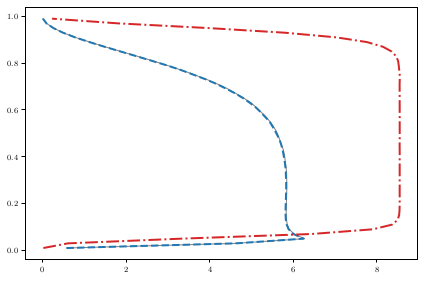

In [15]:
plt.figure()
plt.plot(theta_t, y, **line_t)
plt.plot(theta_1, y, **line_1)
plt.plot(theta_0, y, **line_0)

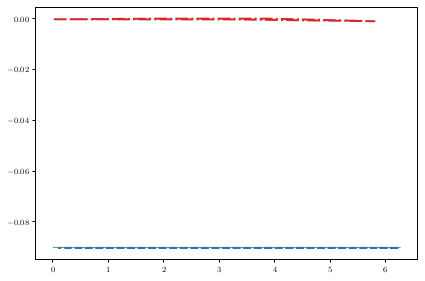

In [30]:
map_0 = [i[0] and j[0] for i,j in zip(theta_0 <= np.max(theta_t), theta_0 >= np.min(theta_t))]
map_1 = [i[0] and j[0] for i,j in zip(theta_1 <= np.max(theta_t), theta_1 >= np.min(theta_t))]

plt.figure()
plt.plot(theta_t, g_t, **line_t)
plt.plot(theta_0[map_0], g_0[map_0], **line_0)
plt.plot(theta_1[map_1], g_1[map_1], **line_1)